# STA9131 Assignment 4-2: Variational AutoEncoders

Before we start, please put your name, ID number, option (and your group members', if any) in following format: e.g., <br>
```
name = 'Kibok Lee'
idnum = '2022123456'
option = 1
group = {
    '2022123457': 'Alice Ahn',
    '2022123458': 'Bob Bae',
    '2022123459': 'Carol Choi',
}
```

In [1]:
# TODO: Put your name, id number, option (and your group members', if any):
# option 1: You did your assignment yourself.
# option 2: You didn't do your assignment yourself,
#           but you added your own comment to show your understanding.
name = 'Juyeon Park'
idnum = '2022311137'
option = 1
group = {}


# Variational Autoencoder

In this notebook, you will implement a variational autoencoder (VAE) and conditional variational autoencoder (CVAE) for generating MNIST images.
Note that an autoencoder seeks to learn a latent representation of training images by using unlabeled data and learning to reconstruct its inputs.
The *variational autoencoder* extends this model by adding a probabilistic spin to the model, allowing us to sample from the learned distribution of the latent space to generate new images at inference time.

[[VAE]](https://arxiv.org/abs/1312.6114) Kingma and Welling, "Auto-Encoding Variational Bayes," ICLR 2014.

[[CVAE]](https://papers.nips.cc/paper/2015/file/8d55a249e6baa5c06772297520da2051-Paper.pdf) Sohn et al., "Learning Structured Output Representation using Deep Conditional Generative Models," NeurIPS 2015.

# Setup Code
Before getting started, we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [2]:
%load_ext autoreload
%autoreload 2

## Google Colab Setup
Next, we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine, you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Now, recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly, then running the folowing cell should print the filenames from the assignment:

```
['common', 'gan.ipynb', 'gan.py', 'pytorch_autograd_and_nn.ipynb', 'pytorch_autograd_and_nn.py', 'vae.ipynb', 'vae.py']
```

In [4]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment.
# Example: If you create a STA9131 folder and put all the files under A4 folder, then 'STA9131/A4'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Lecture/03_VisualRecog/A4'

GOOGLE_DRIVE_PATH = os.path.join('/content/drive/MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(sorted(os.listdir(GOOGLE_DRIVE_PATH)))

['__pycache__', 'common', 'data', 'gan.ipynb', 'gan.py', 'pytorch_autograd_and_nn.ipynb', 'pytorch_autograd_and_nn.pt', 'pytorch_autograd_and_nn.py', 'vae.ipynb', 'vae.py']


Once you have successfully mounted your Google Drive and located the path to this assignment, run the following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from common!
Hello from vae.py!
```

as well as the last edit time for the file `vae.py`.

In [5]:
import os
import sys
import time

sys.path.insert(0, GOOGLE_DRIVE_PATH)

os.environ["TZ"] = "Asia/Seoul"
time.tzset()

from common import hello as hello_common
hello_common()

from vae import hello as hello_vae
hello_vae()

vae_path = os.path.join(GOOGLE_DRIVE_PATH, "vae.py")
vae_edit_time = time.ctime(os.path.getmtime(vae_path))
print("vae.py last edited on %s" % vae_edit_time)

Hello from common!
Hello from vae.py!
vae.py last edited on Fri May 19 19:56:27 2023


## Load Packages

Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [6]:
import common
from common import reset_seed
from common.helpers import count_params, show_images
import torch
from torch.nn import functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0)  # (6.0, 4.0)
plt.rcParams['font.size'] = 16  # 10.0
plt.rcParams['image.interpolation'] = 'nearest'  # 'antialiased'
plt.rcParams['image.cmap'] = 'gray'  # viridis

## Device Setting

We will use `torch.float = torch.float32` for data and `torch.long = torch.int64` for labels.
Please refer to the [PyTorch documentation](https://pytorch.org/docs/stable/tensor_attributes.html#torch-dtype) for more details about data types.

We will use a GPU to accelerate our computation. Run the following cell to make sure you are using a GPU.

In [7]:
if torch.cuda.is_available():
    print('Good to go! You are using', torch.cuda.get_device_name())
    device = torch.device('cuda')
else:
    print('Please set GPU via Edit -> Notebook Settings.')
    device = torch.device('cpu')

print('Default torch.dtype is:', torch.get_default_dtype())

Good to go! You are using Tesla T4
Default torch.dtype is: torch.float32


## Load MNIST

VAEs are notoriously finicky with hyperparameters, and also require many training epochs.
In order to make this notebook approachable, we will be working on the MNIST dataset of 28x28 grayscale images, which has 60k training and 10k test images.
Each image contains a centered image of white digit from 0 to 9 on black background.
This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy.

We load the MNIST dataset using [`torchvision.datasets.MNIST`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html).
Run the following cell to get the data loader.

In [8]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

path = './data'
batch_size = 128

train_dataset = datasets.MNIST(path, train=True, download=True,
                               transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          drop_last=True, num_workers=2)

It is always a good idea to look at examples from the dataset before working with it.
We provide the function `show_images` to visualize the images.
Run the following cell to visualize some images in the dataset.


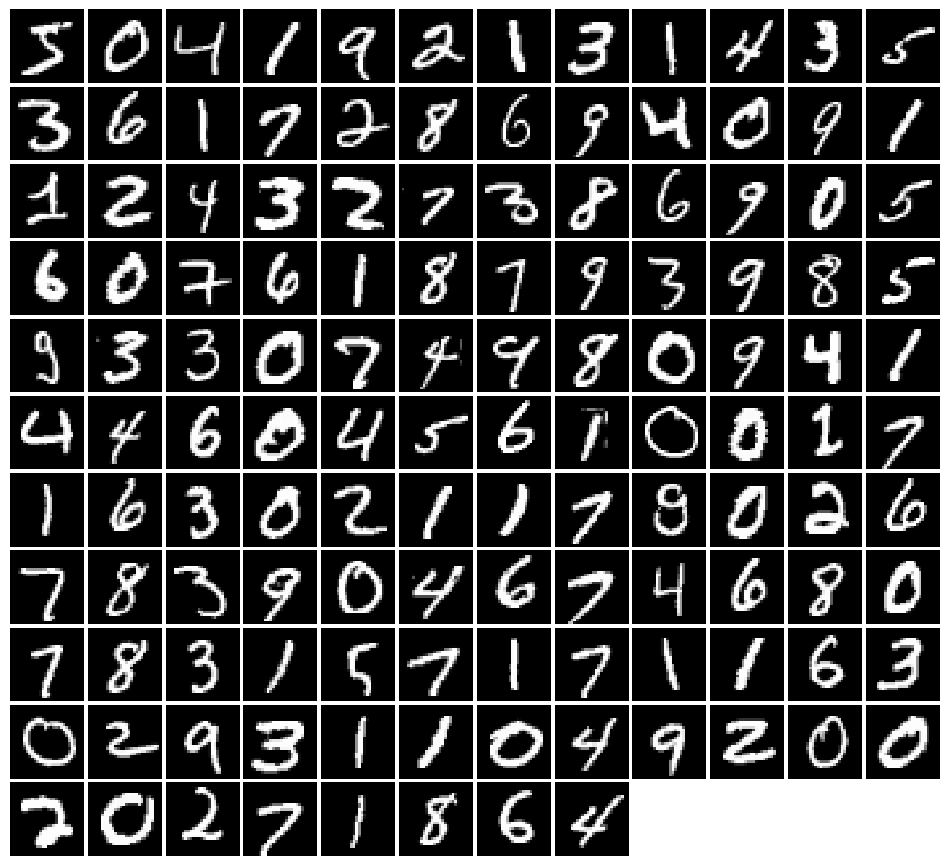

In [9]:
reset_seed(0)

imgs = train_dataset.data[:batch_size]
show_images(imgs)

# Fully-Connected VAE

Our first VAE implementation will consist solely of fully-connected layers.
In this section, you will define the encoder and decoder models in the VAE class and implement the reparametrization trick, forward pass, and loss function to train your first VAE.

## FC-VAE Encoder

To implement a fully-connected VAE model, we will start with the encoder, which takes a batch of images as input and pass them through three Linear + ReLU layers mapping to the hidden space and the last Linear layer mapping to the concatenation of the posterior mean and log-variance of the latent vectors.

Let `D` be the flattened image size, `H` be the hidden dimension, and `Z` be the latent space dimension.

**Implement** `get_encoder` returning a `nn.Sequential` module with the following architecture:

1. Fully-connected layer with input size `D` and output size `H`
2. ReLU
3. Fully-connected layer with input size `H` and output size `H`
4. ReLU
5. Fully-connected layer with input size `H` and output size `H`
6. ReLU
7. Fully-connected layer with input size `H` and output size `2*Z`

Note that you don't have to flatten the input here, as it will be done in the training script.

In [10]:
from vae import get_encoder

model = get_encoder(784, 256, 20)
cur_count = count_params(model)
if cur_count != 342824:
    print('**Incorrect** number of parameters in encoder: ', cur_count)
else:
    print('**Correct** number of parameters in encoder:', cur_count)

**Correct** number of parameters in encoder: 342824


## FC-VAE Decoder

We now define the decoder, which takes the latent space representation and generate a reconstructed image.

Again, let `D` be the flattened image size, `H` be the hidden dimension, and `Z` be the latent space dimension.

**Implement** `get_decoder` returning a `nn.Sequential` module with the following architecture:

1. Fully-connected layer with input size as the latent size `Z` and output size `H`
2. ReLU
3. Fully-connected layer with input size `H` and output size `H`
4. ReLU
5. Fully-connected layer with input size `H` and output size `H`
6. ReLU
7. Fully-connected layer with input size `H` and output size `D`
8. Sigmoid

Here, we apply Sigmoid to clip the image to be in the range of `[0, 1]`.

Note that you don't have to unflatten the output here, it will be done in the training script whenever necessary.

In [11]:
from vae import get_decoder

model = get_decoder(784, 256, 20)
cur_count = count_params(model)
if cur_count != 338448:
    print('**Incorrect** number of parameters in decoder: ', cur_count)
else:
    print('**Correct** number of parameters in decoder:', cur_count)

**Correct** number of parameters in decoder: 338448


## Reparametrization 




We apply a reparametrization trick in order to estimate the posterior $z$ during our forward pass, given the $\mu$ and $\sigma^2$ estimated by the encoder.
A simple way to do this could be to simply generate a normal distribution centered at our  $\mu$ and having a std corresponding to our $\sigma^2$.
However, we would have to backpropogate through this random sampling that is not differentiable.
Instead, we sample initial random data $\varepsilon$ from a fixed distribution, and compute $z$ as a function of ($\mu$, $\sigma^2$, $\varepsilon$):

$$z = \mu + \sigma \varepsilon$$

We can easily find the partial derivatives with respect to $\mu$ and $\sigma^2$ and backpropagate through $z$.
If $\varepsilon \sim \mathcal{N} (0,1)$, then it is easy to verify that the result of our forward pass calculation will be a distribution centered at $\mu$ with variance $\sigma^2$, i.e., $z \sim \mathcal{N} (\mu, \sigma^2)$.

**Implement** `reparametrize` and verify your mean and std error are very small.

In [12]:
from vae import reparametrize

reset_seed(0)

latent_size = 20
size = (1, latent_size)
mu = torch.zeros(size)
logvar = torch.ones(size)

z = reparametrize(mu, logvar)

z_mean = torch.mean(z, dim=-1)
z_std = torch.std(z, dim=-1)
assert z.size() == size

print('Mean Error', common.grad.rel_error(z_mean, torch.tensor(0.57216412)))
print('Std Error', common.grad.rel_error(z_std, torch.tensor(1.76173937)))

Mean Error 0.10654933527225831
Std Error 0.6173282316435363


## FC-VAE

Now, **implement** the `VAE` class by completing the `__init__` and `forward` functions.

The `__init__` function should define the instance variables `encoder` and `decoder`, and the `forward` function should pass the input image through the encoder to calculate the estimation of `mu` and `logvar`, reparametrize to estimate the latent vector `z`, and pass `z` into the decoder to generate a reconstructed image.

Note that we compute the log-variance (instead of variance or standard deviation) to stabilize training and make variance always positive.
This will specifically matter more when you compute reparametrization and the loss function later.

## Loss Function

Before we train our final model, we need to define a loss function.
The loss function for VAEs consists of two terms:
A reconstruction loss term (left) and KL divergence term (right).

$$-\mathbb{E}_{z \sim q_{\phi}(z|x)}[\log p_{\theta}(x|z)] + D_{KL}(q_{\phi}(z|x), p(z)))$$

Note that this is the negative of the variational lower bound.
This ensures that minimizing the loss results in maximizing the variational lower bound.
The reconstruction loss term can be computed by simply using the binary cross-entropy loss between the original input pixels and the output pixels of our decoder.
(For more details about the binary cross-entropy loss, you might check the [PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy.html).)
The KL divergence term works to force the latent space distribution to be close to a prior distribution (we're using a standard normal gaussian as our prior).

To help you out, we have derived an unvectorized form of the KL divergence term for you.
Suppose that $q_\phi(z|x)$ is a $Z$-dimensional diagonal Gaussian with mean $\mu_{z|x}$ of shape $(Z,)$ and standard deviation $\sigma_{z|x}$ of shape $(Z,)$, and that $p(z)$ is a $Z$-dimensional Gaussian with zero mean and unit variance. Then we can write the KL divergence term as:

$$D_{KL}(q_{\phi}(z|x), p(z))) = -\frac{1}{2} \sum_{j=1}^{Z} (1 + \log(\sigma_{z|x}^2)_{j} - (\mu_{z|x})^2_{j} - (\sigma_{z|x})^2_{j})$$

You should implement a vectorized version of this loss that also operates on minibatches, and average the loss across samples in the minibatch.

**Implement** `loss_func` and verify your implementation below.
Your relative error should be very small.

In [13]:
from vae import loss_func

reset_seed(0)

img_size = (3, 4, 5, 6)
img, img_hat = torch.randn(img_size), torch.randn(img_size)

latent_size = (3, 20)
mu, logvar = torch.ones(latent_size), torch.zeros(latent_size)
loss_val = loss_func(torch.sigmoid(img), torch.sigmoid(img_hat), mu, logvar)
print('Loss error', common.grad.rel_error(loss_val, torch.tensor(106.20925)))

Loss error 0.0


## Training FC-VAE

Now that we have our VAE defined and loss function ready, let's train our model!
A training script is provided below.
You don't have to additionally implement anything, but run the cells below.

In [14]:
def train_vae(train_loader, model, optimizer, loss_func, epochs=10,
              device='cpu', cond=False):
    """
    Train a VAE/CVAE!

    Inputs:
    - train_loader: PyTorch Dataloader object that contains our training data
    - model: PyTorch Module object giving the VAE/CVAE model
    - optimizer: PyTorch Optimizer object to use for training the model
    - loss_func: Python function computing the VAE loss
    - epoch: Python integer giving the current epoch number
    - device: device to use for computation. 'cpu' or 'cuda'
    - cond: Python boolean indicating whether training a VAE or CVAE
    """
    num_classes = 10

    # move the model to the proper device (GPU or CPU)
    model = model.to(device)
    model.train()

    end = time.time()
    for epoch in range(epochs):
        train_loss = 0
        for x, y in train_loader:
            # flatten input images
            x = x.view(x.shape[0], -1)
            x = x.to(dtype=torch.float, device=device)

            # forward pass
            if cond:
                y = y.to(dtype=torch.long, device=device)
                y_one_hot = F.one_hot(y, num_classes)
                x_hat, mu, logvar = model(x, y_one_hot)
            else:
                x_hat, mu, logvar = model(x)
            loss = loss_func(x, x_hat, mu, logvar)

            # zero-out grads / backward pass / update model params
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss = train_loss / len(train_loader)
        fmt = 'Train Time: {:6.2f} Epoch: {:1d} Loss: {:6.2f}'
        print(fmt.format(time.time() - end, epoch, train_loss))

Now, run the cell below to train your VAE!
We have pre-defined an Adam optimizer, learning rate, and the number of epochs for you to use.

Training for 10 epochs should take around **3 mins** on CPU or **2 mins** on Tesla T4 GPU, and your loss should be less than `120`.

In [15]:
from vae import VAE

input_size = 784
hidden_dim = 256
latent_size = 20

epochs = 10

vae_model = VAE(input_size, hidden_dim, latent_size)
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)

train_vae(train_loader, vae_model, optimizer, loss_func, epochs, device)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x128 and 20x256)

## Visualize Results

After training our VAE model, we can generate new images.
This process involves the decoder only;
we sample the latent vectors `z` from the prior distribution, and generate new examples by passing these latent vectors into the decoder.

Run the cell below to generate new images.
You should be able to visually recognize many of the digits, although some may be a bit blurry or badly formed.
Our next model will see improvement in these results.

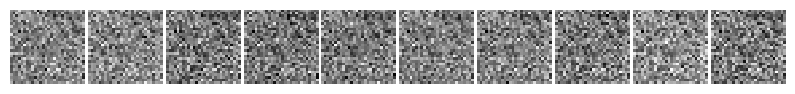

In [16]:
reset_seed(0)

z = torch.randn(10, latent_size, device=device)
vae_model.to(device)
vae_model.eval()
samples = vae_model.decoder(z).data.cpu().numpy()

path = os.path.join(GOOGLE_DRIVE_PATH, 'vae.jpg')
show_images(samples, '1d', path)

## Latent Space Interpolation

As a final visual test of our trained VAE model, we can perform interpolation in latent space.
We generate random latent vectors $z_0$ and $z_1$, and linearly interpolate between them;
we run each interpolated vector through the trained generator to produce an image.

Each row of the figure below interpolates between two random vectors.
For the most part the model should exhibit smooth transitions along each row, demonstrating that the model has learned something nontrivial about the underlying spatial structure of the digits it is modeling.

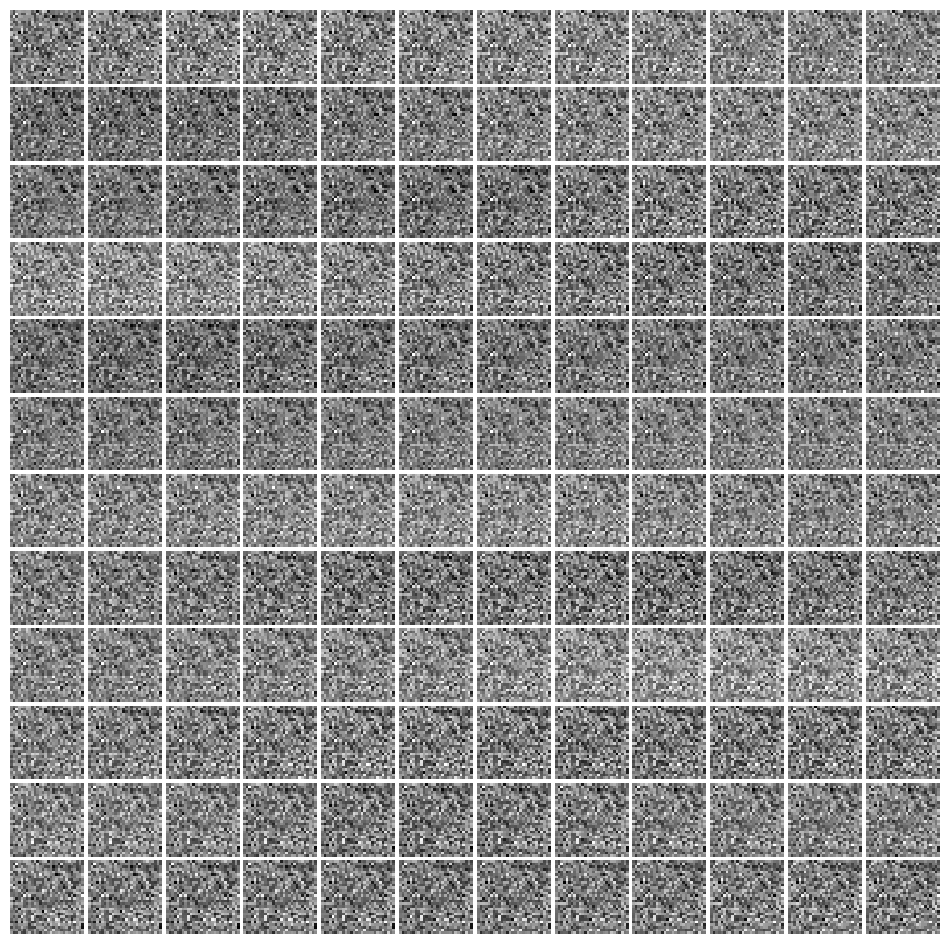

In [17]:
reset_seed(0)

num_images = 12
num_images_sq = num_images * num_images
vae_model.to(device)
vae_model.eval()

z0 = torch.randn(num_images, latent_size, device=device)
z1 = torch.randn(num_images, latent_size, device=device)
w = torch.linspace(0, 1, num_images, device=device).view(num_images, 1, 1)
z = (w * z0 + (1 - w) * z1).transpose(0, 1).reshape(num_images_sq, latent_size)
samples = vae_model.decoder(z).data.cpu().numpy()
show_images(samples)

# Conditional FC-VAE 

The second model is similar to the FC-VAE, but with a slight conditional twist to it.
We will use what we know about the labels of each MNIST image, and *condition* the latent space and image generation on the specific class.
Specifically, instead of $q_{\phi} (z|x)$ and $p_{\phi}(x|z)$, we consider $q_{\phi} (z|x,y)$ and $p_{\phi}(x|z,y)$, where $y$ is the label.

This allows us to do powerful conditional generation at inference time.
For example, we can specifically choose to generate more images of digit 2 instead of simply generating random digits.

## FC-CVAE

The architecture of FC-CVAE is almost the same as FC-VAE, except that we input a one-hot label vector together with (flattened) `x` for `encoder` and `z` for `decoder`.

Let `c` be the one-hot vector, where `c[label] = 1` and `c = 0` elsewhere.
We first convert class labels to one-hot vectors using [`torch.nn.functional.one_hot`](https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html), which is done in the training script we provided.

**Implement** the `CVAE` class by completing the `__init__` and `forward` functions, with the following modifications:

1. Modify the first fully-connected layer of your `get_encoder` to take in not only the flattened input image, but also the one-hot label vector `c`.

2. Modify the first fully-connected layer of your `get_decoder` to project the latent space + one-hot vector to the `hidden_dim`.

3. Using `torch.cat`, combine the flattened input images with the one-hot vectors along with the feature dimension before passing them to `encoder`, and combine the latent vectors with the one-hot vectors along with the feature dimension before passing them to `decoder`.

In [18]:
# sanity check for modified get_encoder and get_decoder

model = get_encoder(784, 256, 10)
cur_count = count_params(model)
if cur_count != 337684:
    print('**Incorrect** number of parameters in encoder: ', cur_count)
else:
    print('**Correct** number of parameters in encoder:', cur_count)

model = get_decoder(784, 256, 20, 10)
cur_count = count_params(model)
if cur_count != 341008:
    print('**Incorrect** number of parameters in decoder: ', cur_count)
else:
    print('**Correct** number of parameters in decoder:', cur_count)

**Correct** number of parameters in encoder: 337684
**Correct** number of parameters in decoder: 341008


## Training FC-CVAE

Now, let's train our CVAE model!
We will use the same training script as the vanilla VAE.

Training for 10 epochs should take around **3 mins** on CPU or **2 mins** on Tesla T4 GPU and your loss should be less than `120`.

In [19]:
from vae import CVAE

input_size = 784
hidden_dim = 256
latent_size = 15
num_classes = 10

epochs = 10

cvae_model = CVAE(input_size, hidden_dim, latent_size, num_classes)
optimizer = optim.Adam(cvae_model.parameters(), lr=1e-3)

train_vae(train_loader, cvae_model, optimizer, loss_func, epochs,
          device, cond=True)

RuntimeError: Tensors must have same number of dimensions: got 1 and 2

## Visualize Results

After training our CVAE model, we can conditionally generate new images!

This time, we can specify the class we want to generate by adding a collection of one-hot vectors of class labels as a matrix.
We use `torch.eye` to create an identity matrix, which effectively gives us one label for each digit.

Run the cell below to generate new images.
You should be able to visually recognize one example per digit, and each digit should be reasonably distinguishable.

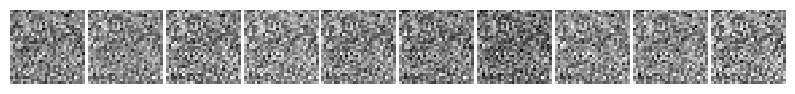

In [20]:
torch.manual_seed(0)

z = torch.randn(10, latent_size, device=device)
c = torch.eye(10, 10, device=device)
z = torch.cat((z, c), dim=-1)
cvae_model.to(device)
cvae_model.eval()
samples = cvae_model.decoder(z).data.cpu().numpy()

path = os.path.join(GOOGLE_DRIVE_PATH, 'cvae.jpg')
show_images(samples, '1d', path)

# Final Check
Done! Before you move, please check if you generated any additional cells and/or modified existing cells.
Your change may not always be automatically saved, so **please MANUALLY SAVE every `*.ipynb` and `*.py` files.**